# Computational Vision - Laboratory

==============================================================================================
## Practice 10: Texture Analysis
==============================================================================================

The exercises of this notebook will show how to perform image similarity search using:

- Gaussian filters
- Descriptors based on texture and color

### Problem we want to solve

- Given a query image **$x$** and a set of images **$X$** we would like to retreive the most similar to **$x$** images from  **$X$**. The function should return a feature vector obtained by averaging each filter response on the image.

**Hint**:
- Note that since at this moment we are focusing on the texture, we will not use the color of the images.

## Looking at the images

In [41]:
%matplotlib inline

import time
import scipy
import numpy as np
import skimage
import os
import matplotlib.pyplot as plt

from skimage import filters
from skimage import io
from skimage.transform import resize

In [42]:
## The images are resized to fasten the computation of features

path = "./images/texturesimages/rice/"
rice_images = [resize(skimage.io.imread(path + f), (64, 64)) for f in os.listdir(path)]

path = "./images/texturesimages/pasta/"
pasta_images = [resize(skimage.io.imread(path + f), (64, 64)) for f in os.listdir(path)]

path = "./images/texturesimages/pizza/"

pizza_images = [resize(skimage.io.imread(path + f), (64, 64)) for f in os.listdir(path)]

In [43]:
## submission has to be done with the entire set of images
## remove this cell for submission

rice_images = rice_images[0:5]
pasta_images = pasta_images[0:5]
pizza_images = pizza_images[0:5]

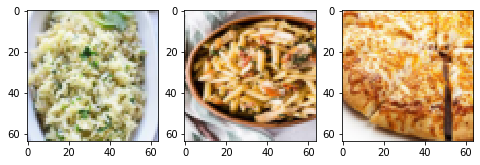

In [44]:
fig, ax= plt.subplots(ncols=3, nrows=1, figsize=(8,8))

ax[0].imshow(rice_images[0])
ax[1].imshow(pasta_images[0])
ax[2].imshow(pizza_images[0])
plt.show()

In [45]:
len(rice_images), len(pasta_images), len(pizza_images)

(5, 5, 5)

# Filter banks

We can apply a collection of multiple filters that we call a filter bank. Note that if we apply $D$ filters our feature vectors will be $D$ dimensional.

The following image shows a filter bank. In the filter bank we typically want filters to capture a combination of scales, orientations of different types of patterns. This particular filter bank is The Leung-Malik (LM) Filter Bank.

<img src="./images_notebook/filter_bank.png">


## Leung-Malik (LM) Filter Bank

In [46]:
import LM_filters

In [47]:
filter_bank = LM_filters.makeLMfilters()
filter_bank.shape

(49, 49, 48)

### Plotting all filters

CPU times: user 889 ms, sys: 12.3 ms, total: 901 ms
Wall time: 928 ms


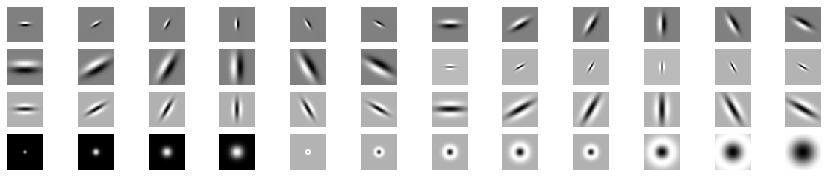

In [48]:
%%time

n_filters = filter_bank.shape[-1]

fig, ax = plt.subplots(ncols=12, nrows=4, figsize=(15,3))

k = 0
for i in range(4):
    for j in range(12):
        ax[i,j].imshow(filter_bank[:,:,k], cmap = 'gray')
        ax[i,j].axis("off")
        k = k + 1

## 10.1 Plot the convolved image by some of the filters


Make a function `visualize_features(im,  filter_bank, n_filters=5)` that recieves the `filter_bank`, an image `im` and an integer `n_filters`. 

The function  must make a plot of two rows containing in the first row, in position $k$, the image convolved by filter $k$. In the second row, in position $k$, the image of the k'th filter. The result for `n_filter=5` should look like 


<img src="./images/filters.png">


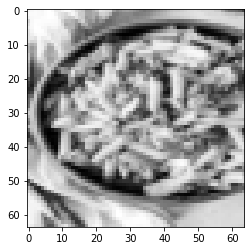

In [49]:
im = pasta_images[0]
im = skimage.color.rgb2gray(pasta_images[0])
plt.imshow(im, cmap="gray")

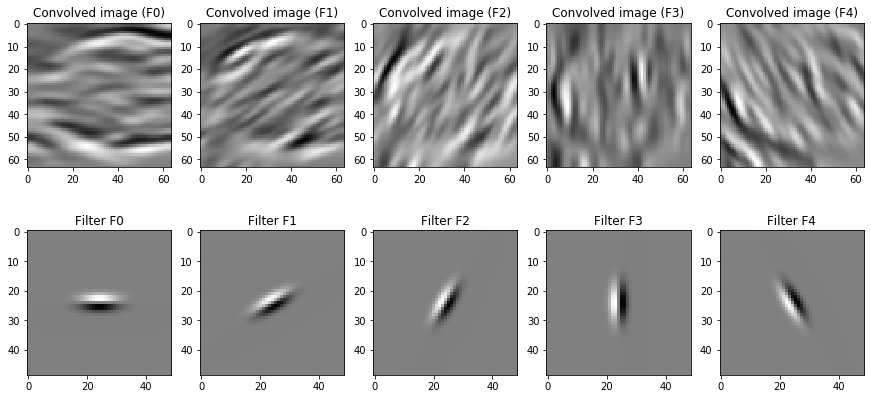

In [50]:
from scipy.ndimage import convolve

def visualize_features(im, filter_bank, n_filters=5):
    fig, ax = plt.subplots(ncols=n_filters, nrows=2, figsize=(15, 7))
    for i in range(n_filters):
        conv_img = convolve(im, filter_bank[:, :, i])
        
        ax[0, i].imshow(conv_img, cmap=plt.cm.gray)
        ax[0, i].set_title(f'Convolved image (F{i})')
        
        ax[1, i].imshow(filter_bank[:, :, i], cmap=plt.cm.gray)
        ax[1, i].set_title(f'Filter F{i}') 

visualize_features(im, filter_bank)

Try the 'visualize_features' function on images from the other two classes.

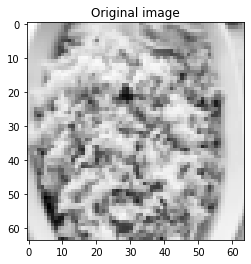

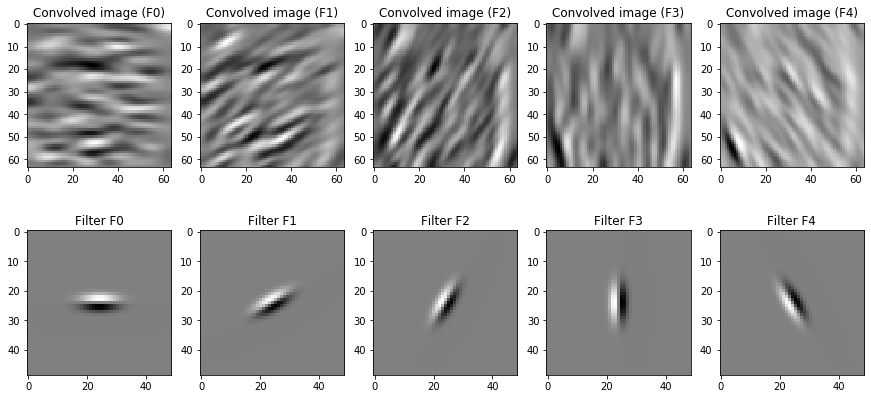

In [51]:
im = rice_images[0]
im = skimage.color.rgb2gray(im)

plt.imshow(im, cmap="gray")
plt.title('Original image')
plt.show()

visualize_features(im, filter_bank)

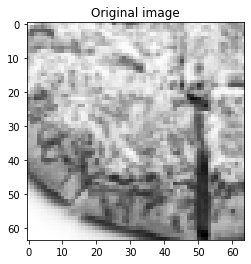

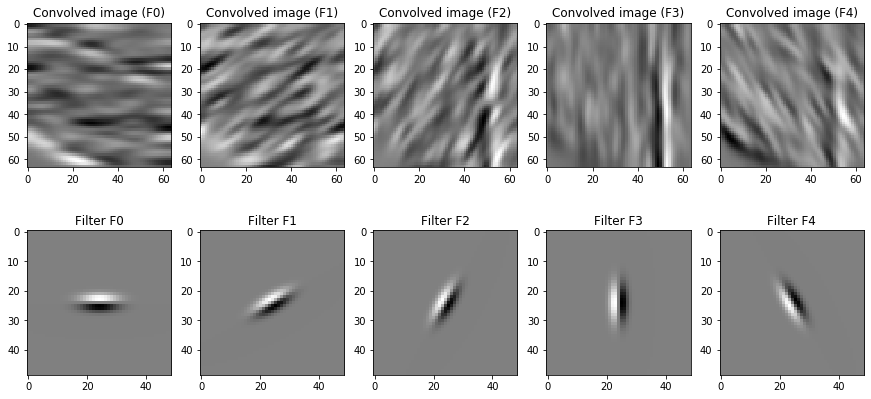

In [52]:
im = pizza_images[0]
im = skimage.color.rgb2gray(im)

plt.imshow(im, cmap="gray")
plt.title('Original image')
plt.show()

visualize_features(im, filter_bank)


## 10.2 Constructing a feature vector for a given image


Given $D$ filters from the filter bank and a single image `image`, make a function `features_from_filter_bank(image, filter_bank, n_filters)` that returns a feature vector of shape `n_filters`. The returned vector must contain at position $k$ the mean of the absolute value of the convolved image by filter $k$.

$$
\text{feat}(x) = \left( \text{mean}( |r_1|), \dots,\text{mean}(|r_D|) \right)
$$



In [53]:
%%time

im = skimage.color.rgb2gray(pasta_images[0])

def features_from_filter_bank(image, filter_bank, n_filters):
    features_for_im = np.zeros(n_filters)
    for i in range(n_filters):
        filtered = convolve(image, filter_bank[i])
        features_for_im[i] = np.mean(np.abs(filtered))
    return features_for_im

features_for_im = features_from_filter_bank(im, filter_bank, n_filters)
print(features_for_im.shape)

(48,)
CPU times: user 3.76 s, sys: 454 ms, total: 4.22 s
Wall time: 4.43 s


## 10.3 Constructing the matrix of the feature vectors for all images

Implement a function `get_class_Features(all_images, filter_bank)` that applies `features_from_filter_bank` to get a feature vector for each of the images in the union of the three datasets (forest, buildings, sunset). It must return a matrix containing at row $k$ feature vector for the input image $k$.


Wall time: 7min 49s

In [54]:
all_images = rice_images + pasta_images + pizza_images
print(len(all_images))

15


In [56]:
%%time

def get_class_features(all_images,  filter_bank):

    n_images = len(all_images)
    n_filters = filter_bank.shape[-1]
    all_feature_vectors=np.zeros((n_images,filter_bank.shape[-1]))

    for idx, image in enumerate(all_images):
        im_gray = skimage.color.rgb2gray(image)
        all_feature_vectors[idx] = features_from_filter_bank(im_gray, filter_bank, n_filters)

    return all_feature_vectors

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.06 µs


In [57]:
%%time

all_feature_vectors=get_class_features(all_images,  filter_bank)
print(all_feature_vectors.shape)

(15, 48)
CPU times: user 52.8 s, sys: 1.92 s, total: 54.7 s
Wall time: 56.4 s


## 10.4 Visualizing the features of an image

Define a function `visualize_features` that given a feature index and an array containing all feature vectors, plots its values for the three datasets using different colors for each dataset (in total plots should contain 3 colors).


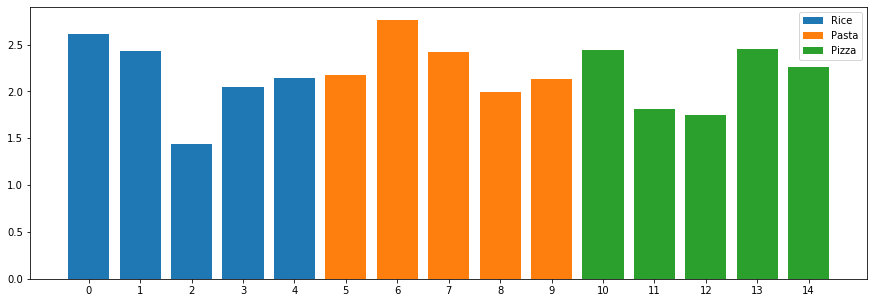

In [92]:
def visualize_features(k, all_feature_vectors):
    knot1 = len(rice_images)
    knot2 = knot1 + len(pasta_images)
    end = all_feature_vectors.shape[0]
    
    plt.figure(figsize=(15, 5))
    
    plt.bar(range(0, knot1), all_feature_vectors[:knot1, k], label='Rice')
    plt.bar(range(knot1, knot2), all_feature_vectors[knot1:knot2, k], label='Pasta')
    plt.bar(range(knot2, end), all_feature_vectors[knot2:end, k], label='Pizza')
    
    plt.xticks(range(15))
    plt.legend(loc='best')
    plt.show()

visualize_features(25, all_feature_vectors)    
# visualize_features(41, all_feature_vectors)

## 10.5 Retrieving the most similar images

Implement a function `retrieve_k_images_from_X(query, X, k)` where `query` is an image, `X` ins the array containing the features from all the images and `k` is an integer. The function should retrieve the `k` most similar images (according to the l2 norm) and the distances from the closest images to the query image. You can include the query image since it is in `X`.

- Make a plot with the first column beeing the query image and the other k columns the closest images in the feature space.

### Similarity search

Let us assume $f(x) \in \mathbb{R}^D$ represents a set of features for $x$. Given a query image $x$ and another image $x^m$ from the database, we can compute the distance between images as
$$
\text{distance}\left( f(x) , \, f(x^m) \right) = \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 =  \sqrt{ \sum_{d=1}^\text{D} \left( f(x)_d - f(x^m)_d  \right)^2 }
$$

then we can find the closest image $x^{m^*}$ from the database to $x$ as $m^* =  \text{argmin}_{m} \{ \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 \}$

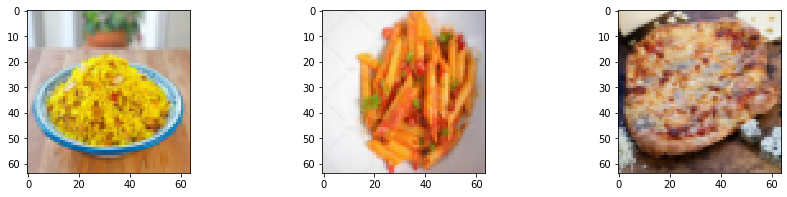

In [95]:
X = np.array(all_feature_vectors)
ind_1 = 1
ind_2 = 6
ind_3 = 11

query_1 = X[ind_1,:]
query_2 = X[ind_2,:]
query_3 = X[ind_3,:]

# Display the query images
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
ax[0].imshow(all_images[ind_1]) 
ax[1].imshow(all_images[ind_2])
ax[2].imshow(all_images[ind_3])

plt.show()

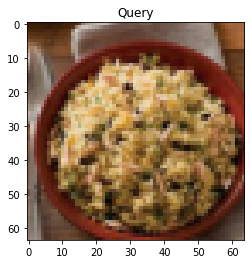

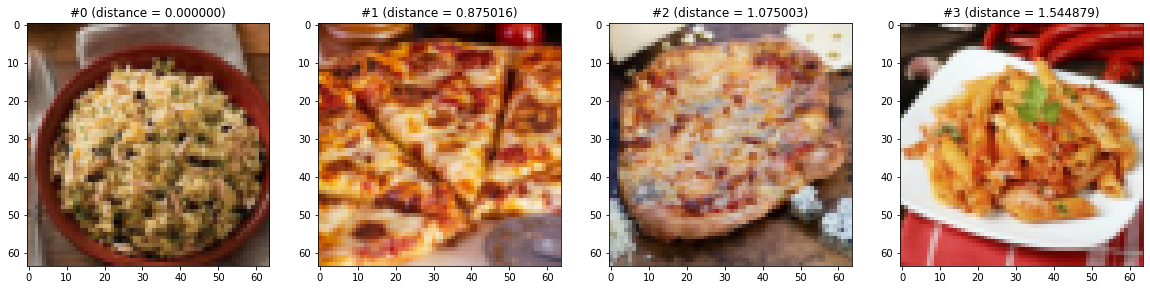

In [115]:
def retrieve_k_images_from_X(query, X, k, visualize=False):
    query_gray = skimage.color.rgb2gray(query)
    n_filters = filter_bank.shape[-1]
    query_feat = features_from_filter_bank(query_gray, filter_bank, n_filters)
    distances = np.zeros(X.shape[0])
    for i in range(0, X.shape[0]):
        distances[i] = np.linalg.norm(query_feat - X[i])
    closest_images_idx = np.argsort(distances)[:k]
    distances = distances[closest_images_idx]
    
    plt.figure()
    plt.imshow(query)
    plt.title('Query')
    
    f, ax = plt.subplots(1, k, figsize=(20, 5))
    for i in range(k):
        ax[i].imshow(all_images[closest_images_idx[i]])
        ax[i].set_title(f'#{i} (distance = {distances[i]:.6f})')
    
    return closest_images_idx, distances

_ = retrieve_k_images_from_X(rice_images[2], X, 4, visualize=True)

## 10.6 Compute the accuracy of the algorithm: given a query image. 

Make a function 

```
accuracy(X, class_labels, k=5, query=x, class_query=y)
```

That takes as input a the dataset `X`, the `class_labels` for the images, the number of images to retrieve `k`, a query image `x` and the class of the query image `y`. Returns as output the number of retrieved images that belong to class `y` divided by the total of images retrieved `k` (this is the accuracy).

**Hint**: be careful to exclude the query image from the retrieved images.

- Compute the accuracy with k=4 with the previous images. Does the accuracy match the images retrieved from the previous exercise?


In [113]:
class_labels = np.concatenate((np.zeros(30), np.ones(30),  2*np.ones(30))).reshape(90,1)

1.0
0.0
0.0


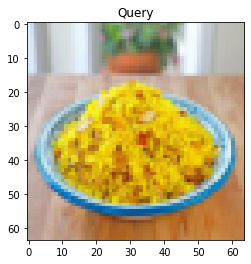

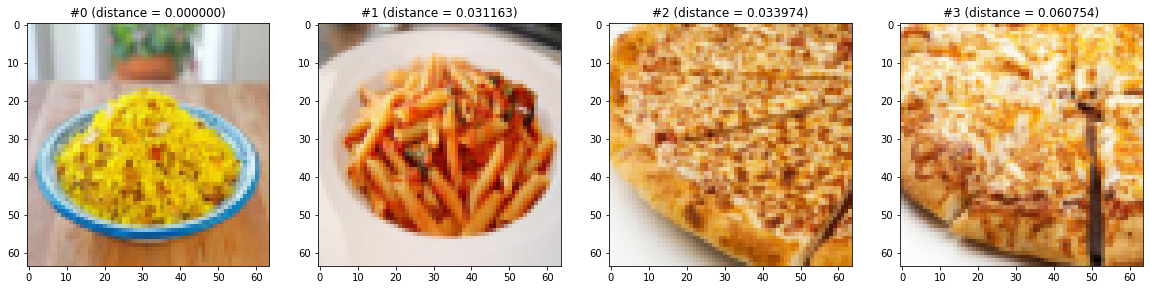

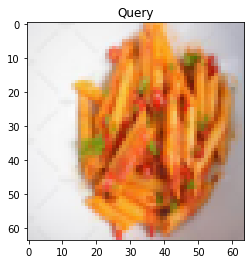

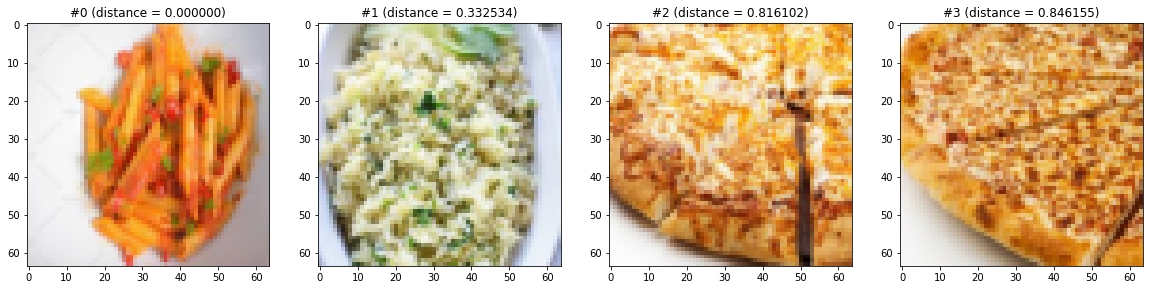

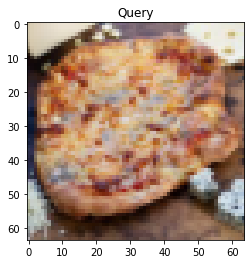

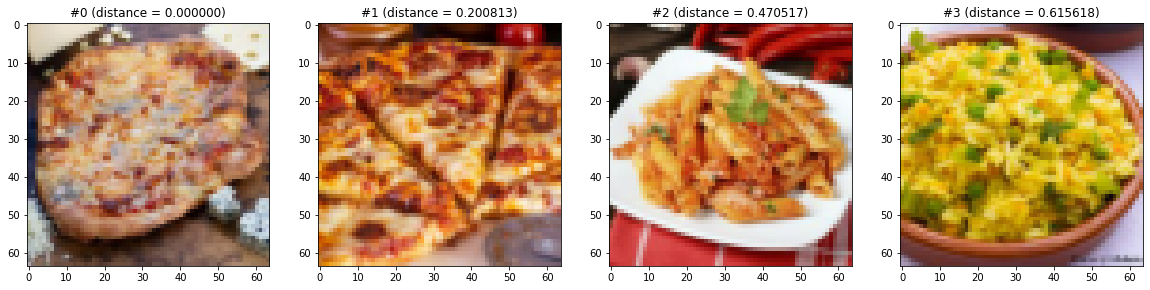

In [116]:
def accuracy(X, class_labels, k, query, class_query):
    closest_images_idx, distances = retrieve_k_images_from_X(query, X, k)
    closest_images_idx = closest_images_idx[1:]
    distances = distances[1:]
    correct = 0
    total = len(closest_images_idx)
    for idx in closest_images_idx:
        if class_labels[idx] == class_query:
            correct += 1
    acc = correct/total
    return acc

print(accuracy(X, class_labels, 4, all_images[ind_1], 0))
print(accuracy(X, class_labels, 4, all_images[ind_2], 1))
print(accuracy(X, class_labels, 4, all_images[ind_3], 2))

## 10.7 Image retrieval based on texture and color. 

Make a function ` lm_features_rgb(image, filter_bank)`  that returns the features from the filter bank concatenated per color. If the previous feature vectors had 49 components now they will have 49*3 components. 

In [ ]:
def lm_features_rgb(image, filter_bank):

    n_filters = len(filter_bank)
    im_conv = np.array(image[:,:,0])
    features_for_im = np.zeros(3*n_filters)
    # Complete        
        
    return features_for_im

In [ ]:
%%time 
lm_rgb_features = lm_features_rgb(all_images[0], filter_bank)
print(lm_rgb_features.shape)

## 10.8 Apply the function to all the images in the dataset

Using ` lm_features_rgb(image, filter_bank)` build the features of all the datapoints in and save them in `X_lm_rgb`.

**Hint**
- You can parallelize the feature building process using `joblib.Parallel`. This will make the computation much faster if you have a processor with more than two threads.

## 10.9 Compute the accuracy of the method using lm rgb features

Use the function implemented in 10.6 to compute the accuracy of the retrieved images using the features that contain color information. Make a plot of the 4 closest images to the query images in the `lm_rgb` space.

- Is the accuracy higher?

In [ ]:
# compute (X_lm_rgb) and cast it as array
X_lm_rgb = np.array(X_lm_rgb)
print(X_lm_rgb.shape)

## Delivery

### Compressed File

- P10_Student1_Student2.zip that includes:
- The notebook P10_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
- The images used to run the notebook.

**Deadline (Campus Virtual): December 16, 11.00 p.m.**